<a href="https://colab.research.google.com/github/xuany823/ADS505_Final_Project/blob/Michelle's-branch/Spotify_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [5]:
# Install the necessary packages

#!pip install xgboost lightgbm
#!pip install dmba

In [43]:
# Data handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Viz
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Sklearn
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV


# Feature selection


# Models
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# dmba
from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary

# # Remove warnings
import warnings
# warnings.filterwarnings('ignore')

# Setup & Data loading

In [7]:
# Clone from our repo into Colab
!git clone https://github.com/xuany823/ADS505_Final_Project.git
%cd ADS505_Final_Project

# Now load CSVs with the path
import pandas as pd

data_path = "Datasets/"

df = pd.read_csv(f"{data_path}spotify_churn_dataset.csv")


Cloning into 'ADS505_Final_Project'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 30), reused 22 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (67/67), 3.85 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/ADS505_Final_Project


In [8]:
# Quick check
print(df.shape)

(8000, 12)


In [9]:
# Quick preview of the df

df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [10]:
# More preview of the df

df.sample(10).T

,4755,5093,6873,4483,5579,3377,2173,4436,6601,7139
user_id,4756,5094,6874,4484,5580,3378,2174,4437,6602,7140
gender,Male,Male,Other,Male,Female,Male,Male,Male,Female,Male
age,47,23,33,52,39,29,58,52,18,30
country,CA,FR,IN,UK,DE,US,FR,CA,FR,UK
subscription_type,Free,Premium,Student,Premium,Free,Premium,Free,Free,Family,Student
listening_time,52,207,71,46,31,298,133,153,178,21
songs_played_per_day,43,86,73,75,85,85,77,97,59,62
skip_rate,0.04,0.06,0.21,0.07,0.13,0.22,0.03,0.39,0.27,0.09
device_type,Desktop,Web,Desktop,Web,Web,Desktop,Desktop,Desktop,Mobile,Mobile
ads_listened_per_week,48,0,0,0,25,0,8,48,0,0


In [11]:
# Get some basic information of the df, including data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


Gender, country, subscription_type, and device_type are categorical data type in the df.

is_churned was the outcome variable.

user_id was not needed, because it provided no meaningful information for analysis.

In [12]:
# Drop user_id column, as it would not be meaningful in the modeling

df = df.drop(columns=['user_id'])

user_id column was dropped, because it would not be needed in below processes, including EDA, preprocessing, and modeling.

In [13]:
# Getting some basic statistics for the variables

df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,8000,3,Male,2691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,8000.0,NaN,NaN,NaN,37.662125,12.740359,16.0,26.0,38.0,49.0,59.0
country,8000,8,AU,1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subscription_type,8000,4,Premium,2115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
listening_time,8000.0,NaN,NaN,NaN,154.06825,84.015596,10.0,81.0,154.0,227.0,299.0
songs_played_per_day,8000.0,NaN,NaN,NaN,50.12725,28.449762,1.0,25.0,50.0,75.0,99.0
skip_rate,8000.0,NaN,NaN,NaN,0.300127,0.173594,0.0,0.15,0.3,0.45,0.6
device_type,8000,3,Desktop,2778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ads_listened_per_week,8000.0,NaN,NaN,NaN,6.943875,13.617953,0.0,0.0,0.0,5.0,49.0
offline_listening,8000.0,NaN,NaN,NaN,0.74775,0.434331,0.0,0.0,1.0,1.0,1.0


In [14]:
# Checking for missing values

df.isna().sum()

,0
gender,0
age,0
country,0
subscription_type,0
listening_time,0
songs_played_per_day,0
skip_rate,0
device_type,0
ads_listened_per_week,0
offline_listening,0


There were no missing values in the dataset.

## Data Preparation

# EDA

is_churned
0    0.741125
1    0.258875
Name: proportion, dtype: float64


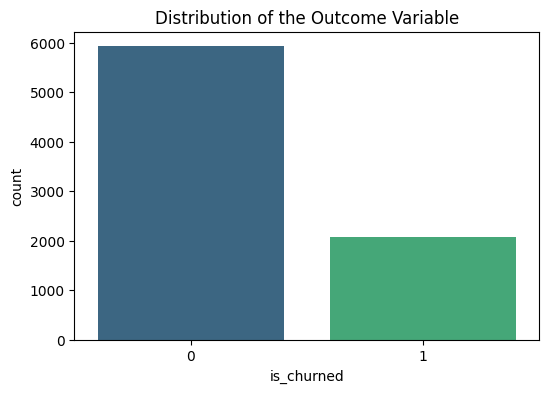

In [15]:
# Distribution of the Outcome variable
print(df['is_churned'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='is_churned', data=df, hue='is_churned', palette='viridis', legend=False)
plt.title('Distribution of the Outcome Variable')
plt.show()

There were a moderate class imbalance in the outcome variable with 1/4 of the customer churned, while 3/4 of the customer stays.

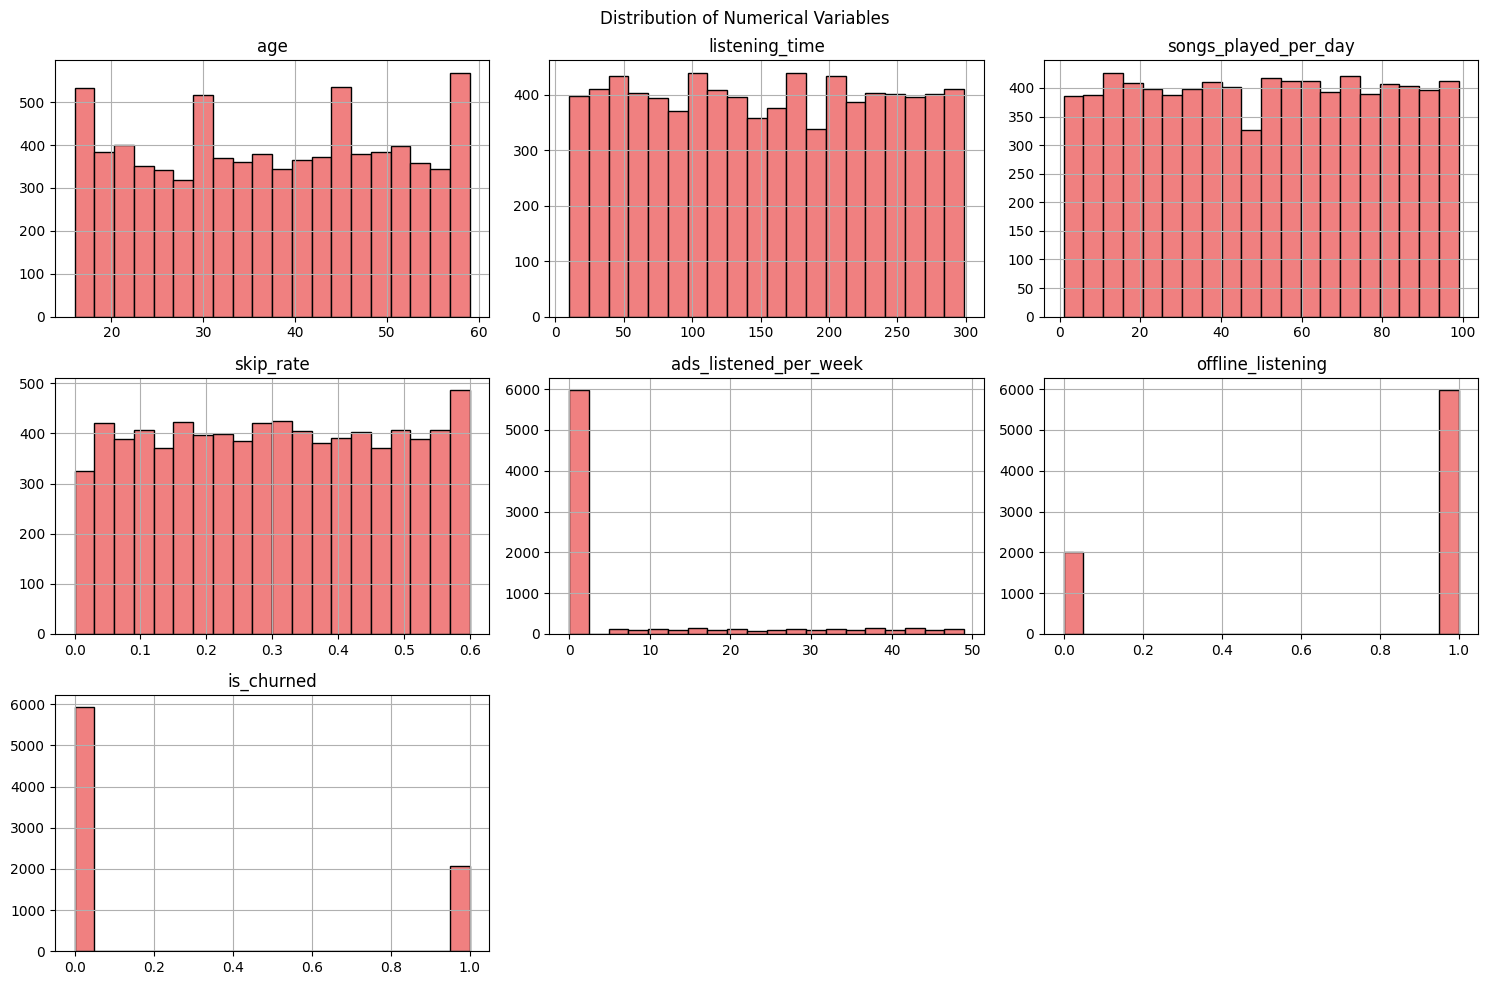

In [16]:
# Distribution of numerical variables

df.hist(figsize=(15, 10), bins=20, edgecolor='black', layout=(3, 3), color='lightcoral')
plt.suptitle('Distribution of Numerical Variables')
plt.tight_layout()
plt.show()

1. Age were mostly evenly distributed among the users, besides four modes at age bins around 15, 30, 45, and 60, indicating there were a slightly more users concentrated in these bins.

2. For listening_time, songs_played_per_day, and skip rate, they were pretty evenly distributed throughout their bins.

3. ads_listened_per_week indicated most people listened to 0 - 5 ads per week.

4. For offiline_listening, 3/4 of the users had used it, while 1/4 hadn't used it.  

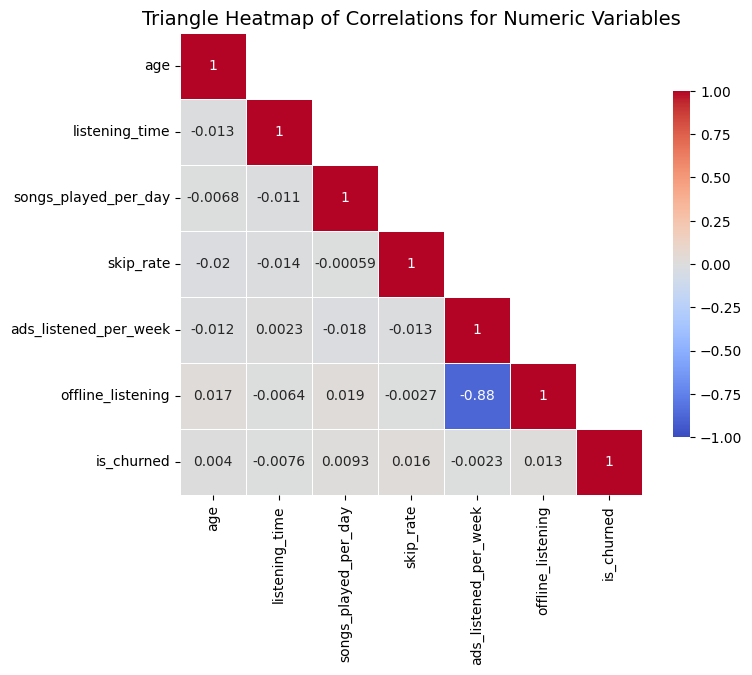

In [17]:
# Construct the correlation heatmap for the numeric variables

# Compute the correlation matrix
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()

# Create a mask for the upper triangle, excluding the diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    center=0,
    annot=True,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title("Triangle Heatmap of Correlations for Numeric Variables", fontsize=14)
plt.show()

1. offline_listening and ads_listened_per_week had strong negative linear relationship with a correlation coefficient of -0.88, suggesting that users who listened offline would often listen to less ads per week. This makes sense, because ads probably not be able to be played offline in Spotify.

2. There were no other obvious linear relationships between the other numeric variables, because their r's were around 0.



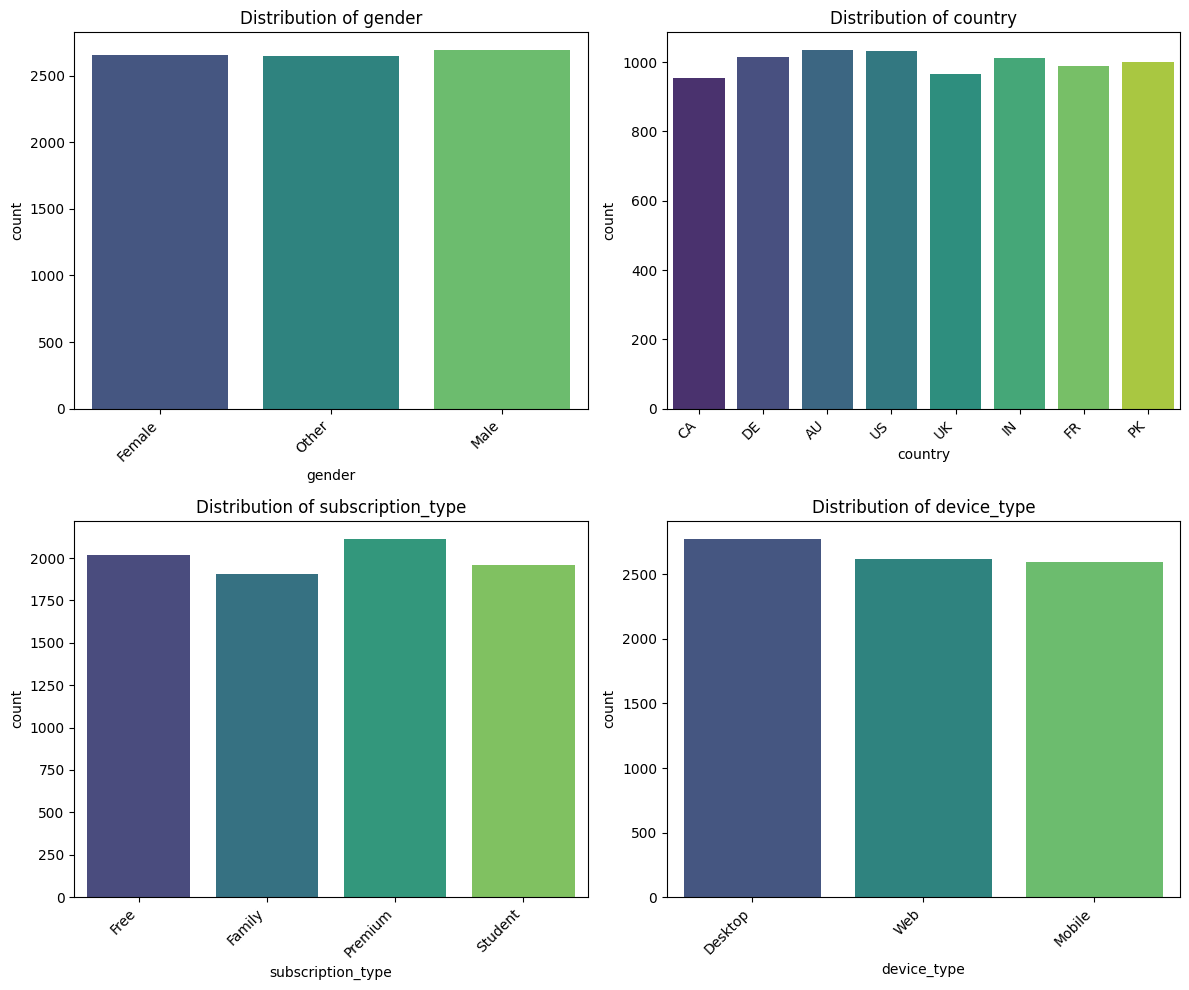

In [18]:
# Count plots for the categorical variables

plt.figure(figsize=(12, 10))

categorical_columns = ['gender', 'country', 'subscription_type', 'device_type']

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df, hue=col, palette='viridis', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

The number in each categories of gender, country, subscription_type, and device_type were mostly evenly distributed.

Most users were males.

Most users were from Australia.

Most users had a premium subscription.

Most users used destop to listen to Spotify.

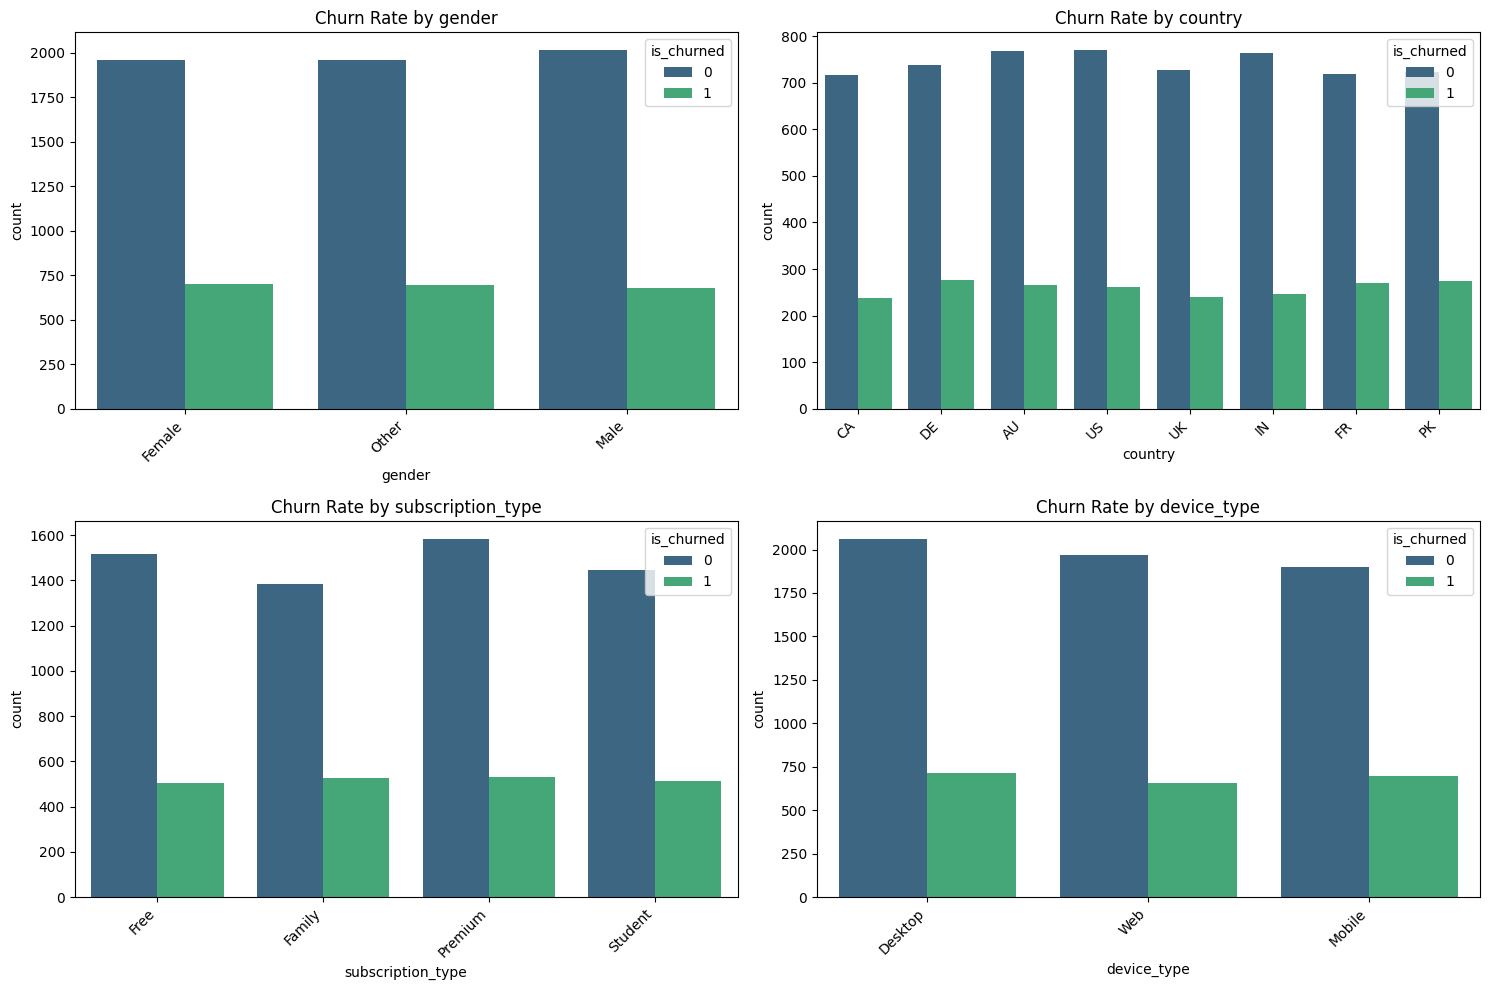

In [19]:
# Count plots for categorical variables vs is_churned

categorical_columns_vs_churn = ['gender', 'country', 'subscription_type', 'device_type', ]

plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_columns_vs_churn, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df, hue='is_churned', palette='viridis')
    plt.title(f'Churn Rate by {col}')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

The churn rates were similar among the categories of gender, country, subscription_type, and device_type.

For example:

1/4 of the male users churned.

1/4 of the Australian users churned.

1/4 of the premium users churned.

1/4 of the desktop users churned.

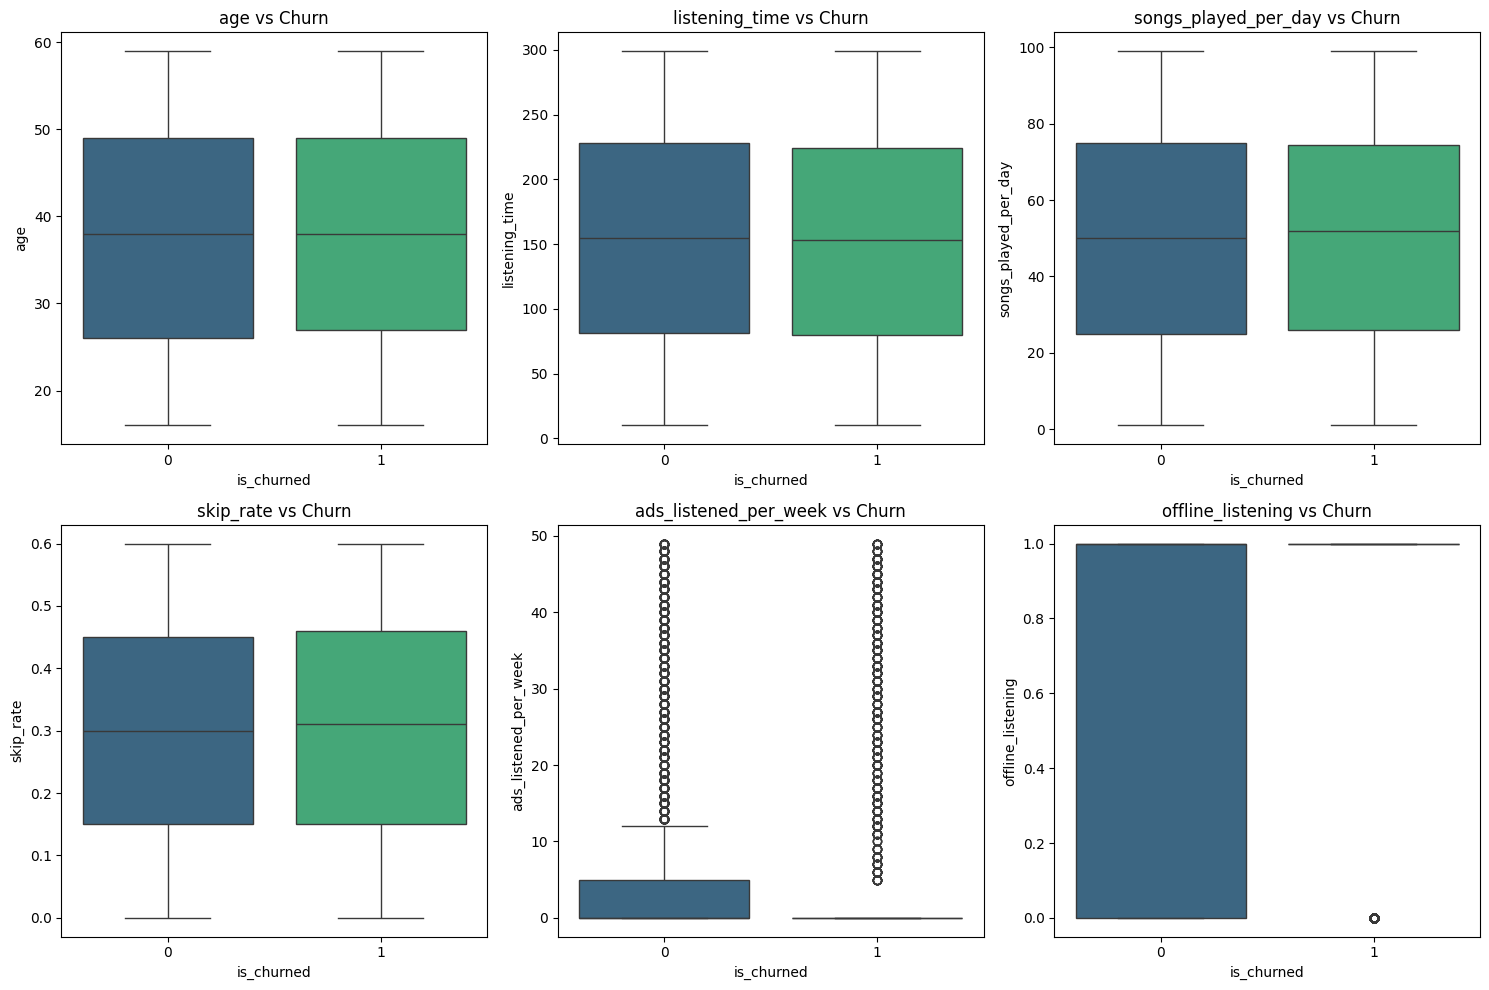

In [20]:
# Box plots of numeric variables vs churn

numeric_columns = df.select_dtypes(include=np.number).drop(columns=['is_churned'])

# Calculate the number of rows and columns needed for subplots
n_cols = 3
n_rows = (len(numeric_columns.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5))

for i, col in enumerate(numeric_columns.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='is_churned', y=col, data=df, hue='is_churned', palette='viridis', legend=False)
    plt.title(f'{col} vs Churn')

plt.tight_layout()
plt.show()

The range of age churned was similar to the unchurned, indicating no particular range of age stood out in the churned users.  

The range of listening_time churned was similar to the unchurned, indicating no particular range of listening_time stood out in the churned users.

The range of song_play_per_day churned was similar to the unchurned, indicating no particular range of song_play_per_day stood out in the churned users.

The range of skip_rate churned was similar to the unchurned, indicating no particular range of skip_rate stood out in the churned users.

ads_listened_per_week vs Churn needed a further breaking down in bins and visualization, because there were many outliers.

offline_listending vs Churn also needed a better visualization, because they were both categorical variable in nature. The boxplot did not provided a justifiable comparison.

In [21]:
# Binning 'ads_listened_per_week'
# Define bin edges and labels
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50']

# Use pd.cut to create the binned column
df['ads_listened_per_week_binned'] = pd.cut(df['ads_listened_per_week'],
                                            bins=bins,
                                            labels=labels,
                                            right=False,
                                            include_lowest=True
                                            )

# Display the distribution of the new binned column
print(df['ads_listened_per_week_binned'].value_counts().sort_index())

ads_listened_per_week_binned
0-5      5982
6-10      204
11-15     222
16-20     234
21-25     198
26-30     217
31-35     222
36-40     245
41-45     243
46-50     233
Name: count, dtype: int64


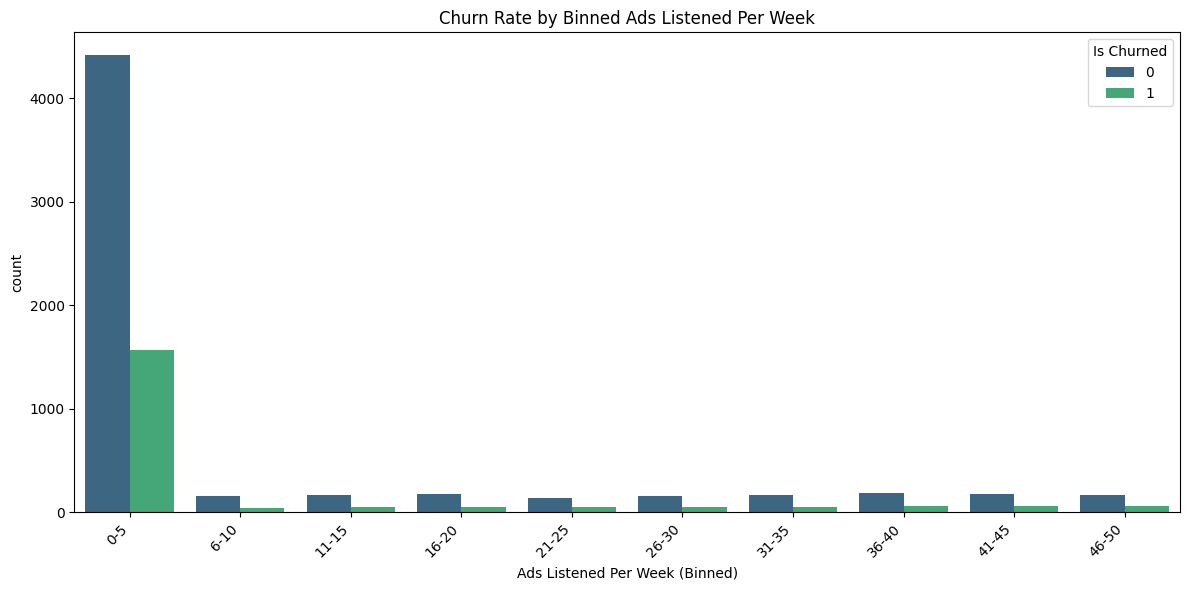

In [22]:
# Count plot of binned 'ads_listened_per_week' vs Churn

plt.figure(figsize=(12, 6))
sns.countplot(x='ads_listened_per_week_binned',
              data=df,
              hue='is_churned',
              palette='viridis'
              )
plt.title('Churn Rate by Binned Ads Listened Per Week')
plt.xlabel('Ads Listened Per Week (Binned)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is Churned')
plt.tight_layout()
plt.show()

Most of the users listened to 0-5 ads per week, but the proportions of churned users were similar across different bins of the ads_listen_per_week.

1/4 of users in each bins churned, indicating churning happened consistently in the similar proportion across different ranges of the ads_listen_per_week.   

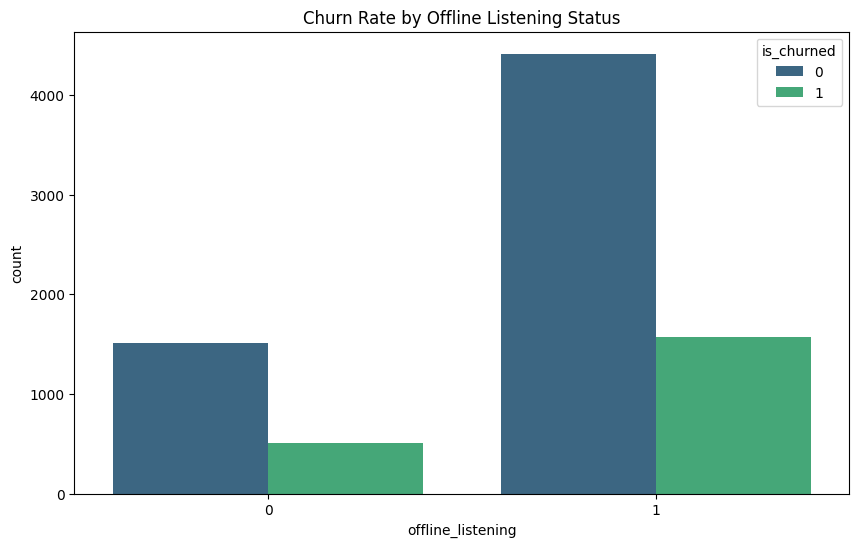

In [23]:
# offline_listening vs Churn

plt.figure(figsize=(10, 6))
sns.countplot(x='offline_listening', data=df, hue='is_churned', palette='viridis')
plt.title('Churn Rate by Offline Listening Status')
plt.show()

Churn rates were similar despite whether the users used the offline_listening function or not.

# Feature Engineering

In [24]:
# Drop ad_listened_per_week_binned

df = df.drop(columns=['ads_listened_per_week_binned'])

Drop the ad_listened_per_week_binned from the data frame, because it might not be useful in the modelling process.

In [25]:
# Change categorical variable data type to categorical

df['offline_listening'] = df['offline_listening'].astype('category')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gender                 8000 non-null   object  
 1   age                    8000 non-null   int64   
 2   country                8000 non-null   object  
 3   subscription_type      8000 non-null   object  
 4   listening_time         8000 non-null   int64   
 5   songs_played_per_day   8000 non-null   int64   
 6   skip_rate              8000 non-null   float64 
 7   device_type            8000 non-null   object  
 8   ads_listened_per_week  8000 non-null   int64   
 9   offline_listening      8000 non-null   category
 10  is_churned             8000 non-null   int64   
dtypes: category(1), float64(1), int64(5), object(4)
memory usage: 633.1+ KB


Changing offline_listening to categorical variable, because the nature of this variable was categorical.

Other categorical variables (gender, country, subscription_type, and device_type) were already in categorical/object data type.

# Preprocessing

In [58]:
# Create the predictors (X) and outcome (y)

X = df.drop(columns=['is_churned'])
y = df['is_churned']

In [59]:
# Split the dataset to get test dataset for performance measurements

X_prep, X_test, y_prep, y_test = train_test_split(
                                    X, y,
                                    test_size=0.2,
                                    random_state=42,
                                    stratify=y
)

X_test.shape

(1600, 10)

Spliting dataset to obtain 20% test dataset as holdout for performance measurements, because 1600 records with around 25 parameters should be sufficient enough to get a general idea of model performance.

In [60]:
# Split the dataset to get validation dataset for Cross-validation

X_train, X_valid, y_train, y_valid = train_test_split(
                                    X_prep, y_prep,
                                    test_size=0.4,
                                    random_state=42,
                                    stratify=y_prep
)

X_valid.shape

(2560, 10)

Further split the prep dataset to obtain 40% as validation dataset for model optimization, because this amount should be enough to train and validate models for optimization.  

In [61]:
# Build proprocessing pipeline
numeric_preproc = Pipeline(steps=[
                            ("scaler", StandardScaler())
])

categorical_preproc = Pipeline(steps=[
                                ("ohe", OneHotEncoder(
                                          handle_unknown="ignore",
                                          sparse_output=False))
])

# Identify numerical and categorical columns
numeric_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns

preprocess = ColumnTransformer(transformers=[
                              ("num", numeric_preproc, numeric_cols),
                              ("cat", categorical_preproc, categorical_cols),
    ],
                              remainder="passthrough"
)

Building preprocess pipeline to do normalization for numeric variables and one-hot encoding for categorical variables.

In [62]:
# Fit preprocessing transformer to X_train

preprocess.fit(X_train)

# Apply preprocessing transformer to X_train, X_test and X_valid

X_train = preprocess.transform(X_train)
X_valid = preprocess.transform(X_valid)
X_test = preprocess.transform(X_test)

# Apply preprocessing transformer to X_prep for using functions w/
# internal cross-validation like LogisticRegressionCV

X_prep = preprocess.transform(X_prep)

In [63]:
# Checking the # of columns

X_train.shape, X_valid.shape, X_test.shape, X_prep.shape

((3840, 25), (2560, 25), (1600, 25), (6400, 25))

In [33]:
# Checking the columns

print(preprocess.get_feature_names_out())

['num__age' 'num__listening_time' 'num__songs_played_per_day'
 'num__skip_rate' 'num__ads_listened_per_week' 'cat__gender_Female'
 'cat__gender_Male' 'cat__gender_Other' 'cat__country_AU'
 'cat__country_CA' 'cat__country_DE' 'cat__country_FR' 'cat__country_IN'
 'cat__country_PK' 'cat__country_UK' 'cat__country_US'
 'cat__subscription_type_Family' 'cat__subscription_type_Free'
 'cat__subscription_type_Premium' 'cat__subscription_type_Student'
 'cat__device_type_Desktop' 'cat__device_type_Mobile'
 'cat__device_type_Web' 'cat__offline_listening_0'
 'cat__offline_listening_1']


Applying the preprocessing to X_train, X_valid, and X_test, as well as X_prep.  

Now X_train and y_train are ready for model training, and X_valid and y_valid are ready for more manual model tuning and optimization through cross-validation.

X_prep and y_prep are more for using functions with internal cross-validation, like LogisticRegressionCV for model tuning and optimization.

X_test and y_test are ready for model performance measurements.

# Feature Selection

# Modeling

## 1. Simple Logistic Regression model (no optimization w/CV)

In [71]:
# Drop some redundant categorical variables
# to prevent multilinearities in logistic regression

# Get the feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# Identify the indices of the columns to drop
columns_to_drop = ['cat__gender_Female',
                   'cat__country_AU',
                   'cat__subscription_type_Premium',
                   'cat__device_type_Desktop',
                   'cat__offline_listening_0']

# Ensure all columns to drop exist in the feature names
existing_columns_to_drop = [name for name in columns_to_drop
                            if name in feature_names]
drop_indices = [i for i, name in enumerate(feature_names)
                          if name in existing_columns_to_drop]

# Drop the columns by index from the NumPy arrays
X_train_lr = np.delete(X_train, drop_indices, axis=1)
X_valid_lr = np.delete(X_valid, drop_indices, axis=1)
X_test_lr = np.delete(X_test, drop_indices, axis=1)
X_prep_lr = np.delete(X_prep, drop_indices, axis=1)

# Build a simple logistic regression model

lr = LogisticRegression(max_iter=1000, random_state=42)

lr.fit(X_train_lr, y_train)

print("Train accuracy score:", lr.score(X_train_lr, y_train))
print("Test accuracy score:", lr.score(X_test_lr, y_test))

# Confusion matrix and Error rates for the simple logistic regression

# Get predictions on the test set for model performance
y_pred_lr = lr.predict(X_test_lr)

# Build the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

print("Confusion Matrix:\n", cm)

# Show detailed classification metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Train accuracy score: 0.7411458333333333
Test accuracy score: 0.74125
Confusion Matrix:
 [[1186    0]
 [ 414    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1186
           1       0.00      0.00      0.00       414

    accuracy                           0.74      1600
   macro avg       0.37      0.50      0.43      1600
weighted avg       0.55      0.74      0.63      1600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The simple logistic regression had an okay accuracy rate of 0.74, but it failed to capture any churned cases as churned, resulting in 0% in sensitivity.

It classified all test records as nonchurned.

## 2. Optimizaed Logistic Regression model (L1 penalty w/5 CV)

In [72]:
# try an optimized logistic regression w/L1 penalty and 5 CV
# X_prep_lr and y_prep used for training and optimization, because
# logisticRegressionCV had a build-in internal Cross-validation function.

lr_opt = LogisticRegressionCV(penalty='l1',
                              solver='liblinear',
                              cv=5,
                              max_iter=1000,
                              random_state=42
)

lr_opt.fit(X_prep_lr, y_prep)

print("Train accuracy score:", lr_opt.score(X_prep_lr, y_prep))
print("Test accuracy score:", lr_opt.score(X_test_lr, y_test))

# Confusion matrix and Error rates for the simple logistic regression

# Get predictions on the test set for model performance
y_pred_lr = lr_opt.predict(X_test_lr)

# Build the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

print("Confusion Matrix:\n", cm)

# Show detailed classification metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Train accuracy score: 0.74109375
Test accuracy score: 0.74125
Confusion Matrix:
 [[1186    0]
 [ 414    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1186
           1       0.00      0.00      0.00       414

    accuracy                           0.74      1600
   macro avg       0.37      0.50      0.43      1600
weighted avg       0.55      0.74      0.63      1600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


There were no improvements on the accuracy and sensitivity in the optimized logistic regression model.

This was probably because linear model might not be able to detect more patterns in this dataset.

# Result & Evaluation

In [ ]:
# test 3

In [ ]:
# test 4 xuan

In [ ]:
#test 5 xuan